In [1]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

C:\Users\Nikhil Bhaskar\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
Using TensorFlow backend.


In [9]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)
print(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=100, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def f1_score(self,p,r):
        return (2*p*r)/(p+r)
    
    def update_network_parameters(self, changes_to_w):
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value
#         print(self.params)    
    
    def compute_accuracy(self, x_val, y_val):
        
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
            
        return predictions,0.769616026711,0.756233595801
    def plot_loss(self,loss):
        print(loss)
        plt.figure()
        plt.plot(np.arange(len(loss)), loss)
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()
        
    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        loss = []
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
               
                self.update_network_parameters(changes_to_w)
#             print('parameters update')
#             print('Parameter k0')
#             print(changes_to_w['W1'])
#             print('Parameter k1')
#             print(changes_to_w['W2'])
#             print('-------------------------------------------------')    
            predictions,r,c  = self.compute_accuracy(x_train, y_train)
            accuracy_train  = np.mean(predictions)
            loss.append(1-accuracy_train) 
            print('Epoch: {0}, Time Spent: {1:.2f}s, Training_Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy_train * 100
            ))
            
            predictions,precision,recall = self.compute_accuracy(x_val, y_val)
            accuracy_test = np.mean(predictions)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Testing_Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy_test * 100
            ))
            
            print(f'Training loss = {1-accuracy_train} VS Testing loss = {1-accuracy_test}')
            
            print("----------------------------------------------------------")
        f1 = self.f1_score(precision,recall)    
        self.plot_loss(loss)
        print(f'f1 Score is {f1}')
        return predictions,loss    



Epoch: 1, Time Spent: 96.90s, Training_Accuracy: 26.89%
Epoch: 1, Time Spent: 99.50s, Testing_Accuracy: 25.70%
Training loss = 0.7311428571428571 VS Testing loss = 0.742952380952381
----------------------------------------------------------
Epoch: 2, Time Spent: 196.98s, Training_Accuracy: 37.55%
Epoch: 2, Time Spent: 199.62s, Testing_Accuracy: 36.83%
Training loss = 0.6245042016806723 VS Testing loss = 0.6317142857142857
----------------------------------------------------------
Epoch: 3, Time Spent: 295.25s, Training_Accuracy: 46.30%
Epoch: 3, Time Spent: 297.89s, Testing_Accuracy: 46.19%
Training loss = 0.5370420168067227 VS Testing loss = 0.5380952380952381
----------------------------------------------------------
Epoch: 4, Time Spent: 392.33s, Training_Accuracy: 50.36%
Epoch: 4, Time Spent: 394.95s, Testing_Accuracy: 50.48%
Training loss = 0.49635294117647055 VS Testing loss = 0.49523809523809526
----------------------------------------------------------
Epoch: 5, Time Spent: 489

Epoch: 34, Time Spent: 3322.28s, Testing_Accuracy: 69.92%
Training loss = 0.29443697478991593 VS Testing loss = 0.3007619047619048
----------------------------------------------------------
Epoch: 35, Time Spent: 3417.56s, Training_Accuracy: 71.10%
Epoch: 35, Time Spent: 3420.23s, Testing_Accuracy: 70.42%
Training loss = 0.2890084033613446 VS Testing loss = 0.29580952380952386
----------------------------------------------------------
Epoch: 36, Time Spent: 3514.53s, Training_Accuracy: 71.65%
Epoch: 36, Time Spent: 3517.19s, Testing_Accuracy: 70.91%
Training loss = 0.2835462184873949 VS Testing loss = 0.2908571428571428
----------------------------------------------------------
Epoch: 37, Time Spent: 3612.42s, Training_Accuracy: 72.20%
Epoch: 37, Time Spent: 3615.00s, Testing_Accuracy: 71.37%
Training loss = 0.2779663865546218 VS Testing loss = 0.28628571428571425
----------------------------------------------------------
Epoch: 38, Time Spent: 3711.33s, Training_Accuracy: 72.73%
Epoch

Epoch: 67, Time Spent: 6542.13s, Testing_Accuracy: 78.22%
Training loss = 0.21527731092436975 VS Testing loss = 0.2178095238095238
----------------------------------------------------------
Epoch: 68, Time Spent: 6636.79s, Training_Accuracy: 78.35%
Epoch: 68, Time Spent: 6639.41s, Testing_Accuracy: 78.15%
Training loss = 0.2165042016806723 VS Testing loss = 0.2184761904761905
----------------------------------------------------------
Epoch: 69, Time Spent: 6734.42s, Training_Accuracy: 78.25%
Epoch: 69, Time Spent: 6737.06s, Testing_Accuracy: 78.09%
Training loss = 0.21746218487394953 VS Testing loss = 0.2191428571428572
----------------------------------------------------------
Epoch: 70, Time Spent: 6833.06s, Training_Accuracy: 78.24%
Epoch: 70, Time Spent: 6835.67s, Testing_Accuracy: 78.10%
Training loss = 0.21757983193277308 VS Testing loss = 0.2189523809523809
----------------------------------------------------------
Epoch: 71, Time Spent: 6930.83s, Training_Accuracy: 78.20%
Epoch

Epoch: 100, Time Spent: 9766.74s, Testing_Accuracy: 79.38%
Training loss = 0.20349579831932774 VS Testing loss = 0.20619047619047615
----------------------------------------------------------
[0.7311428571428571, 0.6245042016806723, 0.5370420168067227, 0.49635294117647055, 0.49329411764705877, 0.48347899159663865, 0.46821848739495797, 0.4483697478991596, 0.4263361344537815, 0.40956302521008403, 0.39672268907563024, 0.3876974789915967, 0.380672268907563, 0.3744873949579832, 0.3693613445378151, 0.3660168067226891, 0.3631932773109243, 0.359764705882353, 0.35680672268907565, 0.35307563025210087, 0.34929411764705887, 0.3458151260504202, 0.34221848739495797, 0.3386722689075631, 0.3351260504201681, 0.3307058823529412, 0.3269747899159664, 0.32262184873949584, 0.3186050420168067, 0.3139159663865546, 0.3098319327731093, 0.3043193277310924, 0.2990252100840336, 0.29443697478991593, 0.2890084033613446, 0.2835462184873949, 0.2779663865546218, 0.27268907563025213, 0.2674957983193277, 0.26203361344537

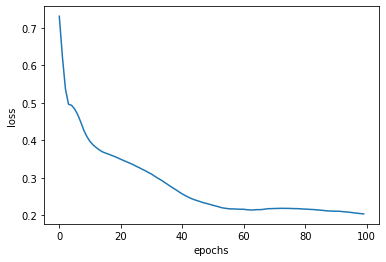

f1 Score is 0.7628661260964605


In [13]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
predictions,loss = dnn.train(x_train, y_train, x_val, y_val)